# SETUP

In [1]:
import pandas as pd

import numpy as np

import pydicom as dicom

import matplotlib.pyplot as plt

from glob import glob

import seaborn as sns

import cv2

import torch
import torchvision

import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler, Subset
from torch.utils.data import ConcatDataset
import torchvision.models as models
import torch.optim as optim
from torchvision import models

from transformers import ViTForImageClassification, ViTFeatureExtractor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

from PIL import Image

import timm

import os

from tqdm import tqdm

import random

import gc

import warnings

import time

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
def seeding(SEED):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    torch.manual_seed(SEED)
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(SEED)
        torch.cuda.manual_seed_all(SEED)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print('seeding done!!!')

def flush():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
    print('Memory Flushed')

In [3]:
seeding(2024)
flush()

seeding done!!!

Memory Flushed


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
root_dir = "/kaggle/input/spine-mri-nchu/Original"
batch_size = 16
num_classes = 1  # Binary classification (Patient, Healthy)

print("Device: ", device)

Device:  cuda


# BUILDING DATASET

## Create file paths

In [5]:
# Function to create a list of image file paths
def make_datapath_list(root_dir):
    data_paths = []
    class_names = os.listdir(root_dir)
    
    for class_name in class_names:
        class_dir = os.path.join(root_dir, class_name)
        if os.path.isdir(class_dir):
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                data_paths.append((image_path, class_name))
    
    return data_paths

# Function to create a list of 'Healthy' image file paths
def make_healthy_datapath_list(root_dir):
    data_paths = []
    target_path = os.path.join(root_dir, 'Healthy', '*.jpg')
    
    for path in glob(target_path):
        data_paths.append((path, 'Healthy'))
    
    return data_paths

## Create Dataset Class

In [6]:
# Dataset class for Spine images
class SpineDataset(Dataset):
    def __init__(self, data_paths, transform=None):
        self.data_paths = data_paths
        self.transform = transform
        self.class_to_index = {'Healthy': 0, 'Patient': 1}

    def __len__(self):
        return len(self.data_paths)
    
    def get_labels(self):
        labels = [label for _, label in self.data_paths]
        label_indices = [self.class_to_index[label] for label in labels]
        return label_indices

    def __getitem__(self, idx):
        image_path, label = self.data_paths[idx]
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        label_idx = self.class_to_index[label]
        label_tensor = torch.tensor(label_idx, dtype=torch.long)
        
        return {'image': image, 'label': label_tensor}

# Dataset class for Healthy Spine images with augmented transforms
class HealthySpineDataset(Dataset):
    def __init__(self, data_paths, transform=None):
        self.data_paths = data_paths
        self.transform = transform
        self.class_to_index = {'Healthy': 0, 'Patient': 1}

    def __len__(self):
        return len(self.data_paths)
    
    def get_labels(self):
        labels = [label for _, label in self.data_paths]
        label_indices = [self.class_to_index[label] for label in labels]
        return label_indices

    def __getitem__(self, idx):
        image_path, label = self.data_paths[idx]
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        label_idx = self.class_to_index[label]
        label_tensor = torch.tensor(label_idx, dtype=torch.long)
        
        return {'image': image, 'label': label_tensor}

# Custom ConcatDataset to get labels
class CustomConcatDataset(ConcatDataset):
    def __init__(self, datasets):
        super(CustomConcatDataset, self).__init__(datasets)
    
    def get_labels(self):
        results = []
        for dataset in self.datasets:
            if hasattr(dataset, 'get_labels'):
                results.extend(dataset.get_labels())
        return results

In [7]:
# Define transformations
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

augmented_train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

augmented_val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [8]:
# Create datapath lists
spine_datapath = make_datapath_list(root_dir)

# spine_train_datapath, spine_val_datapath = train_test_split(spine_datapath, test_size=0.2, random_state=42)

# First split: 70% train, 30% temp (validation + test)
spine_train_datapath, temp_datapath = train_test_split(spine_datapath, test_size=0.3, random_state=42)

# Second split: 20% of original total for validation and 10% for test
spine_val_datapath, spine_test_datapath = train_test_split(temp_datapath, test_size=0.5, random_state=42)


spine_train_dataset = SpineDataset(spine_train_datapath, transform=augmented_train_transform)
spine_val_dataset = SpineDataset(spine_val_datapath, transform=val_transform)
spine_test_dataset = SpineDataset(spine_test_datapath, transform=val_transform)

# healthy_spine_datapath = make_healthy_datapath_list(root_dir)
# healthy_spine_train_datapath, healthy_spine_val_datapath = train_test_split(healthy_spine_datapath, test_size=0.2, random_state=42)

# augmented_healthy_spine_train_dataset = HealthySpineDataset(healthy_spine_train_datapath, transform=augmented_train_transform)
# augmented_healthy_spine_val_dataset = HealthySpineDataset(healthy_spine_val_datapath, transform=val_transform)

# combined_spine_train_dataset = CustomConcatDataset([spine_train_dataset, augmented_healthy_spine_train_dataset])
# combined_spine_val_dataset = CustomConcatDataset([spine_val_dataset, augmented_healthy_spine_val_dataset])

In [9]:
# Get the sizes of the datasets
spine_train_size = len(spine_train_dataset)
spine_val_size = len(spine_val_dataset)
spine_test_size = len(spine_test_dataset)
# healthy_train_size = len(augmented_healthy_spine_train_dataset)
# healthy_val_size = len(augmented_healthy_spine_val_dataset)
# combined_train_size = len(combined_spine_train_dataset)
# combined_val_size = len(combined_spine_val_dataset)

# Print the sizes
print(f"Size of spine_train_dataset: {spine_train_size}")
print(f"Size of spine_val_dataset: {spine_val_size}")
print(f"Size of spine_test_dataset: {spine_test_size}")
# print(f"Size of augmented_healthy_spine_train_dataset: {healthy_train_size}")
# print(f"Size of augmented_healthy_spine_val_dataset: {healthy_val_size}")
# print(f"Size of combined_spine_train_dataset: {combined_train_size}")
# print(f"Size of combined_spine_val_dataset: {combined_val_size}")

Size of spine_train_dataset: 200

Size of spine_val_dataset: 43

Size of spine_test_dataset: 44


## Create DataLoader

In [10]:
# # DataLoader with WeightedRandomSampler
# class_weights = torch.tensor([1, 1], dtype=torch.float)

# # Training DataLoader
# train_labels = combined_spine_train_dataset.get_labels()
# samples_weights = class_weights[train_labels]
# sampler = WeightedRandomSampler(weights=samples_weights, 
#                                 num_samples=len(samples_weights), 
#                                 replacement=True)

# spine_train_loader = DataLoader(
#     combined_spine_train_dataset,
#     batch_size=batch_size,
#     sampler=sampler
# )

# # Validation DataLoader
# val_labels = combined_spine_val_dataset.get_labels()
# samples_weights = class_weights[val_labels]
# sampler = WeightedRandomSampler(weights=samples_weights, 
#                                 num_samples=len(samples_weights), 
#                                 replacement=True)

# spine_val_loader = DataLoader(
#     combined_spine_val_dataset,
#     batch_size=batch_size,
#     sampler=sampler
# )

In [11]:
# Training DataLoader
spine_train_loader = DataLoader(
    spine_train_dataset,
    batch_size=batch_size,
)

# Validation DataLoader
spine_val_loader = DataLoader(
    spine_val_dataset,
    batch_size=batch_size,
)

# Validation DataLoader
spine_test_loader = DataLoader(
    spine_test_dataset,
    batch_size=batch_size,
)

In [12]:
# # DataLoader with WeightedRandomSampler
# batch_size = 16
# class_weights = torch.tensor([1, 1], dtype=torch.float)

# # Training DataLoader
# train_labels = spine_train_dataset.get_labels()
# samples_weights = class_weights[train_labels]
# sampler = WeightedRandomSampler(weights=samples_weights, 
#                                 num_samples=len(samples_weights), 
#                                 replacement=True)

# spine_train_loader = DataLoader(
#     spine_train_dataset,
#     batch_size=batch_size,
#     sampler=sampler
# )

# # Validation DataLoader
# val_labels = spine_val_dataset.get_labels()
# samples_weights = class_weights[val_labels]
# sampler = WeightedRandomSampler(weights=samples_weights, 
#                                 num_samples=len(samples_weights), 
#                                 replacement=True)

# spine_val_loader = DataLoader(
#     spine_val_dataset,
#     batch_size=batch_size,
#     sampler=sampler
# )

## Show images in the dataset

In [13]:
# def imshow(img, ax):
#     """Function to show an image"""
#     img = img / 2 + 0.5  # unnormalize
#     npimg = img.numpy()
#     ax.imshow(np.transpose(npimg, (1, 2, 0)))
#     ax.axis('off')

# def show_images_from_loader(loader, num_images_per_row=16):
#     """Function to show images from a DataLoader in a grid"""
#     for batch in loader:
#         images = batch['image']
#         labels = batch['label']
        
#         num_images = images.size(0)
#         num_rows = (num_images + num_images_per_row - 1) // num_images_per_row
        
#         fig, axes = plt.subplots(num_rows, num_images_per_row, figsize=(num_images_per_row * 2, num_rows * 2))
#         fig.suptitle('Images and Labels')
        
#         for i in range(num_images):
#             row = i // num_images_per_row
#             col = i % num_images_per_row
#             ax = axes[row, col] if num_rows > 1 else axes[col]
#             imshow(images[i], ax)
#             ax.set_title(f'Label: {labels[i].item()}')

#         # Hide any unused subplots
#         for i in range(num_images, num_rows * num_images_per_row):
#             row = i // num_images_per_row
#             col = i % num_images_per_row
#             ax = axes[row, col] if num_rows > 1 else axes[col]
#             ax.axis('off')

#         plt.show()

# # Assuming spinal_train_loader and spinal_val_loader are already defined
# # Display images from the training dataset
# print("Training Dataset Images:")
# show_images_from_loader(spine_train_loader)

# # Display images from the validation dataset
# print("Validation Dataset Images:")
# show_images_from_loader(spine_val_loader)

# BUILD MODEL

In [14]:
# # Load the EfficientNet model with pretrained weights
# spine_model = models.efficientnet_v2_s(pretrained=True)

# # #print(spine_model)

# # Modify the classifier part
# # spine_model.classifier = nn.Sequential(
# #     nn.Linear(spine_model.classifier[-1].in_features, 512),
# #     nn.ReLU(),
# #     nn.Dropout(0.5),
# #     nn.Linear(512, num_classes),
# # )

# spine_model.classifier = nn.Sequential(
#     nn.Dropout(p=0.5, inplace=False),
#     nn.Linear(in_features=1280, out_features=num_classes, bias=True)
# )

# # #print(spine_model)

In [15]:
# Initialize model
vgg16_model = models.vgg16(pretrained=True)
resnet_model = models.resnet50(pretrained=True)

# Modify the last layer of both models to match the number of output classes (e.g., binary classification)
vgg16_model.classifier[6] = nn.Linear(4096, 1)  # For binary classification
resnet_model.fc = nn.Linear(2048, 1)  # For binary classification

vgg16_model.to(device)
resnet_model.to(device)

vgg16_optimizer = optim.Adam(vgg16_model.parameters(), lr=1e-4)
resnet_optimizer = optim.Adam(resnet_model.parameters(), lr=1e-4)

vgg16_loss_fn = nn.BCEWithLogitsLoss()
resnet_loss_fn = nn.BCEWithLogitsLoss()


# Define the optimizer, scheduler, and loss function
#spinal_optimizer = optim.Adam(spinal_model.parameters(), lr=1e-4, weight_decay=1e-4)
#spinal_scheduler = optim.lr_scheduler.StepLR(spinal_optimizer, step_size=1, gamma=0.2)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth

100%|██████████| 528M/528M [00:02<00:00, 196MB/s]

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth

100%|██████████| 97.8M/97.8M [00:00<00:00, 208MB/s]


# TRAIN MODEL

In [16]:
def train_model(model, train_loader, val_loader, model_optimizer, model_loss_fn, device, num_epochs=50, patience=2, save_path='model_best_early_stopping.pth'):
    # Initialize lists to store metrics
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_val_loss = float('inf')
    trials = 0

    # DataFrame to store metrics
    metrics_df = pd.DataFrame(columns=['Epoch', 'Train Loss', 'Train Accuracy', 'Val Loss', 'Val Accuracy'])

    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        # Training loop
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
            for batch in train_loader:
                images = batch['image'].to(device)
                labels = batch['label'].to(device).float().unsqueeze(1)  # Ensure correct shape and type
                
                model_optimizer.zero_grad()
                outputs = model(images)  # Raw logits
                loss = model_loss_fn(outputs, labels)  # BCEWithLogitsLoss
                loss.backward()
                model_optimizer.step()

                running_loss += loss.item()
                preds = torch.sigmoid(outputs)  # Convert logits to probabilities for accuracy calculation
                predicted = (preds > 0.5).long()
                correct_predictions += (predicted == labels).sum().item()
                total_samples += labels.size(0)

                pbar.update(1)

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_predictions / total_samples
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation loop
        model.eval()
        val_running_loss = 0.0
        val_correct_predictions = 0
        val_total_samples = 0

        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(device)
                labels = batch['label'].to(device).float().unsqueeze(1)
                outputs = model(images)
                loss = model_loss_fn(outputs, labels)

                val_running_loss += loss.item()
                preds = torch.sigmoid(outputs)
                predicted = (preds > 0.5).long()
                val_correct_predictions += (predicted == labels).sum().item()
                val_total_samples += labels.size(0)

        val_loss = val_running_loss / len(val_loader)
        val_accuracy = val_correct_predictions / val_total_samples
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Epoch duration
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, "
              f"Duration: {epoch_duration:.2f} seconds")

        # Add metrics to DataFrame
        metrics_df = pd.concat([metrics_df, pd.DataFrame({
            'Epoch': [epoch + 1],
            'Train Loss': [train_loss],
            'Train Accuracy': [train_accuracy],
            'Val Loss': [val_loss],
            'Val Accuracy': [val_accuracy],
        })], ignore_index=True)

        # Early stopping and model saving
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trials = 0
            torch.save(model.state_dict(), save_path)
        else:
            trials += 1
            if trials >= patience:
                print('Early stopping')
                break

    return metrics_df, train_losses, val_losses, train_accuracies, val_accuracies

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    """
    Plots training and validation losses and accuracies.

    Args:
    - train_losses (list): List of training losses per epoch.
    - val_losses (list): List of validation losses per epoch.
    - train_accuracies (list): List of training accuracies per epoch.
    - val_accuracies (list): List of validation accuracies per epoch.
    """
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 8))

    # Plot training and validation loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function to show an image
def imshow(img, title=None):
    """
    Displays a single image with optional title.
    
    Args:
    - img (torch.Tensor): The image tensor to display.
    - title (str): Optional title for the image.
    """
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.show()

# Function to show a grid of images with their predicted labels
def show_images_with_predictions(images, labels, preds, num_images=10):
    """
    Displays a grid of images along with their true and predicted labels.
    
    Args:
    - images (torch.Tensor): Batch of images.
    - labels (torch.Tensor): True labels for the images.
    - preds (torch.Tensor): Predicted labels for the images.
    - num_images (int): Number of images to display (default is 10).
    """
    num_images = min(num_images, len(images))  # Adjust num_images if fewer images are available
    images = images[:num_images]  # Get the first num_images images
    labels = labels[:num_images]
    preds = preds[:num_images]
    
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    for idx in range(num_images):
        ax = axes[idx]
        img = images[idx] / 2 + 0.5  # unnormalize
        npimg = img.numpy()
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        label = labels[idx].item()
        pred = preds[idx].item()
        ax.set_title(f"Label: {label}\nPred: {pred}")
        ax.axis('off')
    plt.show()

# Function to evaluate the model and display predictions
def evaluate_and_show_predictions(model, test_loader, device, num_images=10):
    """
    Evaluates the model on the test dataset and displays predictions.
    
    Args:
    - model (torch.nn.Module): The model to evaluate.
    - test_loader (DataLoader): DataLoader for the test dataset.
    - device (torch.device): Device to run the model on (CPU or GPU).
    - num_images (int): Number of images to display (default is 10).
    """
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in test_loader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device).float().unsqueeze(1)
            outputs = model(images)
            preds = torch.sigmoid(outputs)
            predicted = (preds > 0.5).long()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            # Show images with predictions
            show_images_with_predictions(images.cpu(), labels.cpu(), predicted.cpu(), num_images=num_images)

    return all_labels, all_preds

def evaluate_metrics_and_confusion_matrix(all_labels, all_preds, class_names=['Healthy', 'Patient']):
    """
    Computes precision, recall, F1-score, and displays the confusion matrix.

    Args:
    - all_labels (list or np.array): True labels.
    - all_preds (list or np.array): Predicted labels.
    - class_names (list of str): Class names for the confusion matrix axes (default ['Healthy', 'Patient']).
    """
    # Compute precision, recall, and F1-score
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    # Print metrics
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Compute and plot the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

In [17]:
vgg16_metrics_df, vgg16_train_losses, vgg16_val_losses, vgg16_train_accuracies, vgg16_val_accuracies  = train_model(vgg16_model, spine_train_loader, spine_val_loader, vgg16_optimizer, vgg16_loss_fn, device, save_path= 'vgg16_model_best_early_stopping.pth')

Epoch 1/50: 100%|██████████| 13/13 [00:05<00:00,  2.44batch/s]


Epoch 1/50, Train Loss: 0.6279, Train Accuracy: 0.6000, Val Loss: 0.3677, Val Accuracy: 0.8837, Duration: 6.00 seconds


Epoch 2/50: 100%|██████████| 13/13 [00:03<00:00,  3.84batch/s]


Epoch 2/50, Train Loss: 0.4738, Train Accuracy: 0.7650, Val Loss: 0.1785, Val Accuracy: 0.9302, Duration: 3.85 seconds


Epoch 3/50: 100%|██████████| 13/13 [00:03<00:00,  3.84batch/s]


Epoch 3/50, Train Loss: 0.3526, Train Accuracy: 0.8500, Val Loss: 0.1680, Val Accuracy: 0.9302, Duration: 3.78 seconds


Epoch 4/50: 100%|██████████| 13/13 [00:03<00:00,  3.74batch/s]


Epoch 4/50, Train Loss: 0.4000, Train Accuracy: 0.8250, Val Loss: 0.2260, Val Accuracy: 0.9070, Duration: 4.00 seconds


Epoch 5/50: 100%|██████████| 13/13 [00:03<00:00,  3.79batch/s]


Epoch 5/50, Train Loss: 0.1980, Train Accuracy: 0.9450, Val Loss: 0.1725, Val Accuracy: 0.9535, Duration: 3.83 seconds

Early stopping


In [18]:
resnet_metrics_df, resnet_train_losses, resnet_val_losses, resnet_train_accuracies, resnet_val_accuracies = train_model(resnet_model, spine_train_loader, spine_val_loader, resnet_optimizer, resnet_loss_fn, device, save_path= 'resnet_model_best_early_stopping.pth')

Epoch 1/50: 100%|██████████| 13/13 [00:03<00:00,  4.26batch/s]


Epoch 1/50, Train Loss: 0.5450, Train Accuracy: 0.7150, Val Loss: 0.4759, Val Accuracy: 0.7674, Duration: 3.43 seconds


Epoch 2/50: 100%|██████████| 13/13 [00:02<00:00,  4.41batch/s]


Epoch 2/50, Train Loss: 0.2306, Train Accuracy: 0.9150, Val Loss: 0.9243, Val Accuracy: 0.5349, Duration: 3.29 seconds


Epoch 3/50: 100%|██████████| 13/13 [00:02<00:00,  4.40batch/s]


Epoch 3/50, Train Loss: 0.1331, Train Accuracy: 0.9600, Val Loss: 0.2778, Val Accuracy: 0.8605, Duration: 3.29 seconds


Epoch 4/50: 100%|██████████| 13/13 [00:02<00:00,  4.49batch/s]


Epoch 4/50, Train Loss: 0.0635, Train Accuracy: 0.9850, Val Loss: 0.3439, Val Accuracy: 0.8605, Duration: 3.26 seconds


Epoch 5/50: 100%|██████████| 13/13 [00:02<00:00,  4.49batch/s]


Epoch 5/50, Train Loss: 0.0622, Train Accuracy: 0.9800, Val Loss: 0.1547, Val Accuracy: 0.9535, Duration: 3.24 seconds


Epoch 6/50: 100%|██████████| 13/13 [00:02<00:00,  4.44batch/s]


Epoch 6/50, Train Loss: 0.0678, Train Accuracy: 0.9750, Val Loss: 0.1529, Val Accuracy: 0.9535, Duration: 3.30 seconds


Epoch 7/50: 100%|██████████| 13/13 [00:02<00:00,  4.50batch/s]


Epoch 7/50, Train Loss: 0.0385, Train Accuracy: 0.9900, Val Loss: 0.0819, Val Accuracy: 0.9767, Duration: 3.23 seconds


Epoch 8/50: 100%|██████████| 13/13 [00:02<00:00,  4.45batch/s]


Epoch 8/50, Train Loss: 0.0188, Train Accuracy: 0.9950, Val Loss: 0.1892, Val Accuracy: 0.9535, Duration: 3.38 seconds


Epoch 9/50: 100%|██████████| 13/13 [00:03<00:00,  4.18batch/s]


Epoch 9/50, Train Loss: 0.0142, Train Accuracy: 0.9950, Val Loss: 0.2013, Val Accuracy: 0.9070, Duration: 3.52 seconds

Early stopping


In [19]:
# Display the metrics table
vgg16_metrics_df

,Epoch,Train Loss,Train Accuracy,Val Loss,Val Accuracy
0,1,0.627920,0.600,0.367686,0.883721
1,2,0.473776,0.765,0.178488,0.930233
2,3,0.352623,0.850,0.168013,0.930233
3,4,0.400049,0.825,0.225960,0.906977
4,5,0.198038,0.945,0.172455,0.953488


In [20]:
resnet_metrics_df

,Epoch,Train Loss,Train Accuracy,Val Loss,Val Accuracy
0,1,0.545027,0.715,0.475884,0.767442
1,2,0.230647,0.915,0.924307,0.534884
2,3,0.133108,0.960,0.277814,0.860465
3,4,0.063522,0.985,0.343865,0.860465
4,5,0.062240,0.980,0.154710,0.953488
5,6,0.067782,0.975,0.152949,0.953488
6,7,0.038534,0.990,0.081918,0.976744
7,8,0.018821,0.995,0.189185,0.953488
8,9,0.014186,0.995,0.201269,0.906977


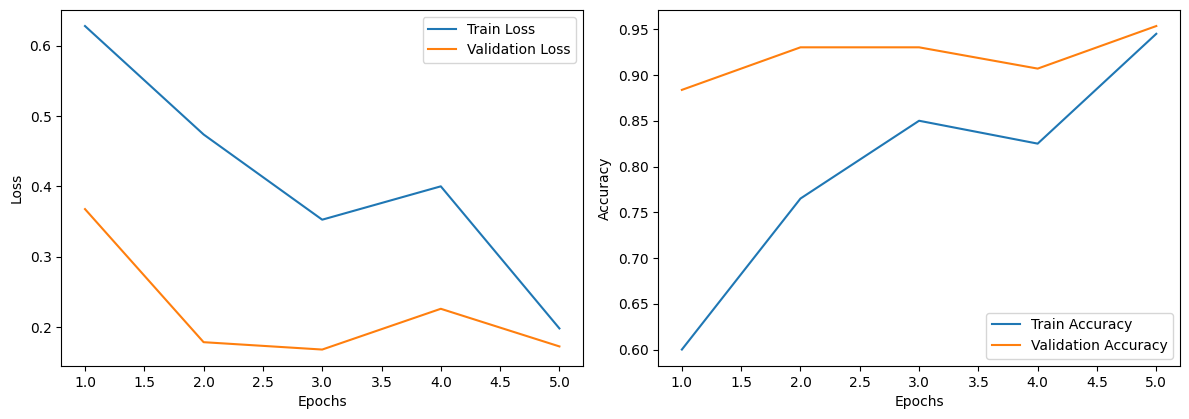

In [21]:
plot_metrics(vgg16_train_losses, vgg16_val_losses, vgg16_train_accuracies, vgg16_val_accuracies)

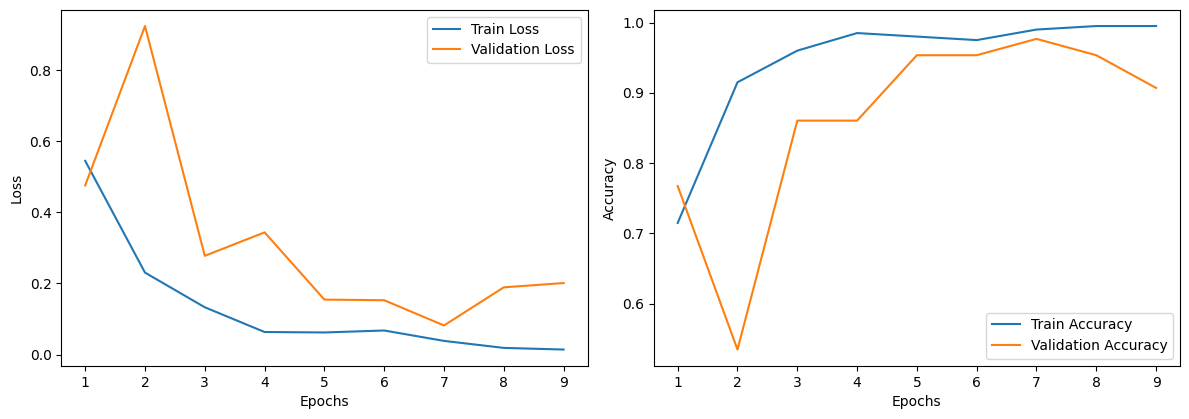

In [22]:
plot_metrics(resnet_train_losses, resnet_val_losses, resnet_train_accuracies, resnet_val_accuracies)

In [23]:
# Load the best model
vgg16_model.load_state_dict(torch.load('/kaggle/working/vgg16_model_best_early_stopping.pth'))
resnet_model.load_state_dict(torch.load('/kaggle/working/resnet_model_best_early_stopping.pth'))

<All keys matched successfully>

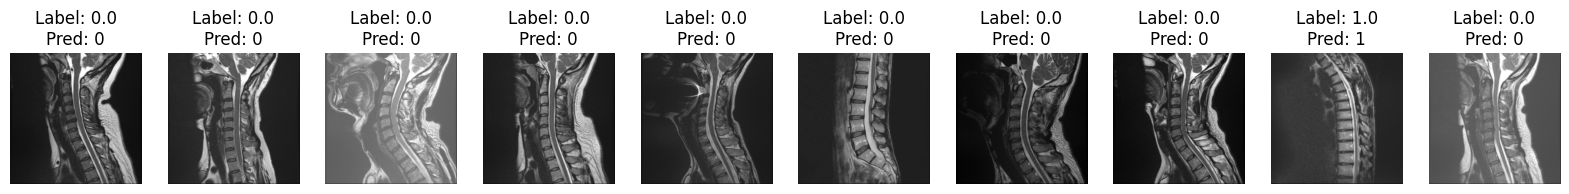

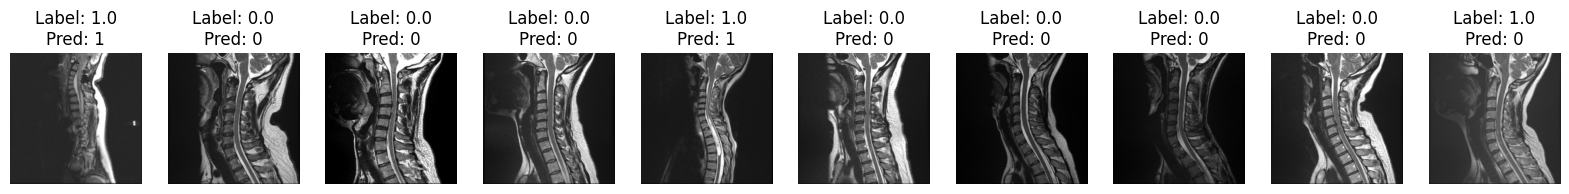

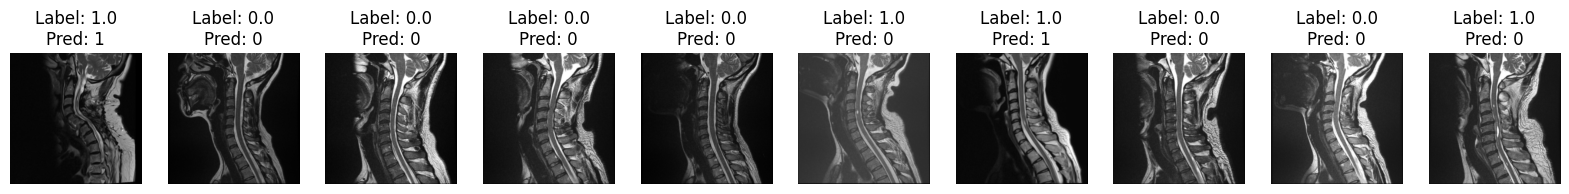

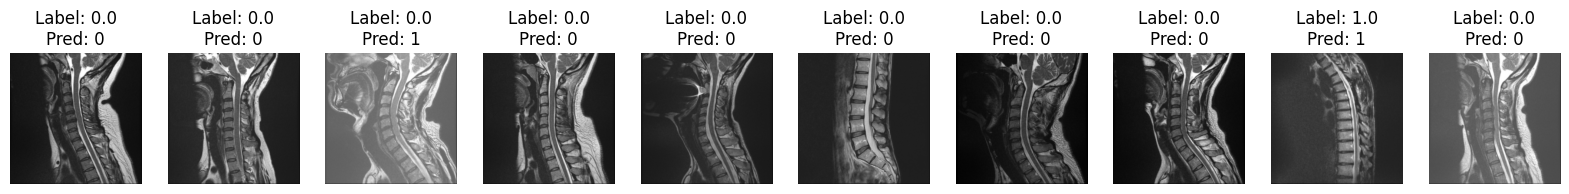

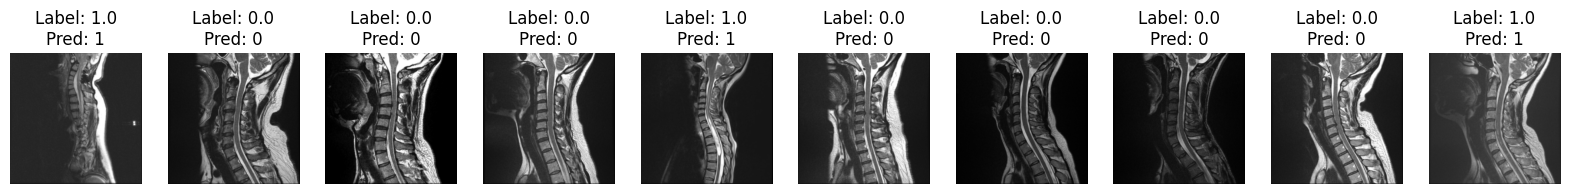

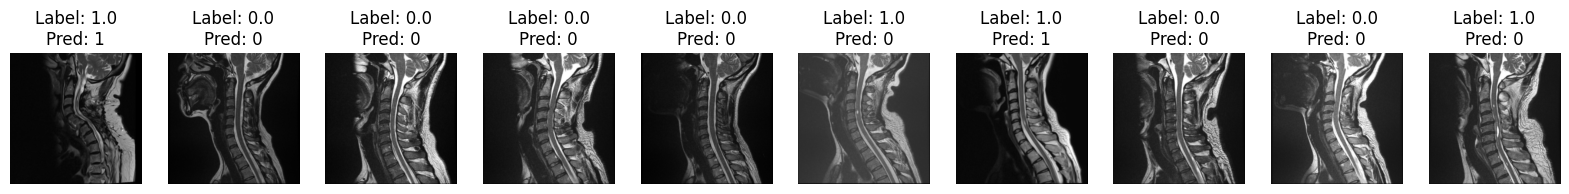

In [24]:
vgg16_labels, vgg16_preds = evaluate_and_show_predictions(vgg16_model,spine_test_loader, device)
resnet_labels, resnet_preds = evaluate_and_show_predictions(resnet_model,spine_test_loader, device)

Precision: 1.0000

Recall: 0.7059

F1 Score: 0.8276


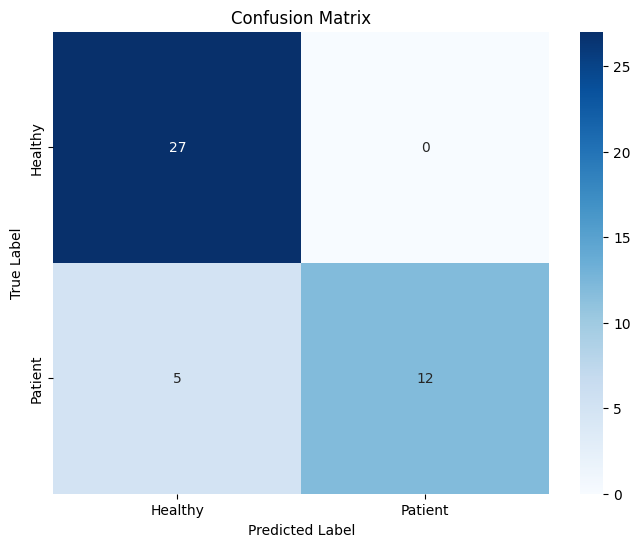

In [25]:
evaluate_metrics_and_confusion_matrix(vgg16_labels, vgg16_preds)

Precision: 0.9375

Recall: 0.8824

F1 Score: 0.9091


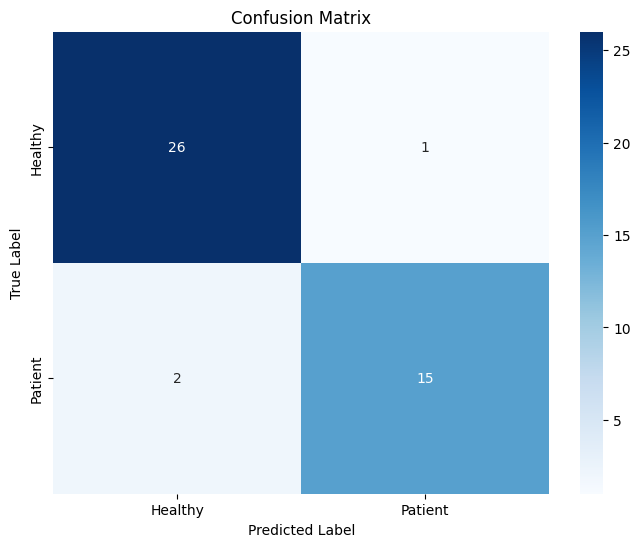

In [26]:
evaluate_metrics_and_confusion_matrix(resnet_labels, resnet_preds)

In [27]:
def get_model_predictions(model, loader, device):
    """
    Get predictions from a model on the loader's dataset.
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in loader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device).float().unsqueeze(1)
            outputs = model(images)
            preds = torch.sigmoid(outputs)
            predicted = (preds > 0.5).long()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_labels), np.array(all_preds)

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Step 1: Get predictions from both models on the training dataset
vgg16_train_labels, vgg16_train_preds = get_model_predictions(vgg16_model, spine_train_loader, device)
resnet_train_labels, resnet_train_preds = get_model_predictions(resnet_model, spine_train_loader, device)


# Step 2: Combine predictions to create the meta-features
meta_features_train = np.hstack([vgg16_train_preds.reshape(-1, 1), resnet_train_preds.reshape(-1, 1)])
meta_labels_train = vgg16_train_labels  # These are the true labels

# Step 3: Train a Logistic Regression model as the meta-learner
meta_learner = LogisticRegression()
meta_learner.fit(meta_features_train, meta_labels_train.ravel())

# Step 4: Get predictions from the test dataset
vgg16_test_labels, vgg16_test_preds = get_model_predictions(vgg16_model, spine_test_loader, device)
resnet_test_labels, resnet_test_preds = get_model_predictions(resnet_model, spine_test_loader, device)

assert np.array_equal(vgg16_test_labels, resnet_test_labels)

meta_features_test = np.hstack([vgg16_test_preds.reshape(-1, 1), resnet_test_preds.reshape(-1, 1)])
meta_labels_test = vgg16_test_labels

# Step 5: Use the meta-learner to make predictions
meta_test_preds = meta_learner.predict(meta_features_test)

# Evaluate the meta-learner's performance
meta_accuracy = accuracy_score(meta_labels_test, meta_test_preds)
print(f"Meta-Learner Accuracy: {meta_accuracy:.4f}")

Meta-Learner Accuracy: 0.9318
